# EEE6504 - HW3 #
## Jackson Cornell  | Michael Kim ##

In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

## Functions ##

In [2]:
# Gaussian kernel
def Kernel(x, kernel_size) :
    return np.exp(-x**2 / kernel_size**2)

In [3]:
# Vector quantization algorithm
def QV(C, err, threshold, embedding_size, sample, current_error) :
    # compute minimum distance
    minimum = 1e100
    min_index = 0
    if (len(C) != 0) :
        min_index = np.argmin(abs(sample[embedding_size-1] - np.array(C)[:,embedding_size-1]))
        minimum = abs(sample[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
    # update codebook
    if (minimum > threshold) :
        C.append(sample)
        err.append(current_error)
    else :
        err[min_index] += current_error
    return C, err

In [4]:
# QKLMS filter with MSE cost function
def QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * np.array(err[0:i]).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size)
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [5]:
# QKLMS filter with MCC cost function
def QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * (np.array(err[0:i]) * Kernel(np.array(err[0:i]), entropy_kernel_size)).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size) / entropy_kernel_size**2
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [6]:
# KRLS filter with MSE cost function
def QKRLS_MSE(x, d, regularizer, kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer + Kernel(0, kernel_size)])**-1
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # compute vectors
            z = np.array(Q@h)
            r = regularizer + Kernel(0, kernel_size) - z.T@h
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            #else :
            #    a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, np.array(a)

In [7]:
# KRLS filter with MSE cost function
def QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size)**-1])
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # compute vectors
                z = np.array(Q@h)
                phi = Kernel(e[i], entropy_kernel_size)**-1
                r = regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size) - z.T@h
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, a

In [8]:
# transform input signal with weights in RKHS
def KernelFilter(x, a, kernel_size, embedding_size) :
    # determine min size between x and a
    epochs = x.size #min(x.size, a.size)
    # concatenate with 0s
    x = np.concatenate((x, np.zeros(embedding_size)))
    # define input matrix and vectors
    y = np.zeros(epochs)
    input_m = np.zeros((epochs, embedding_size))
    for j in range(epochs) :
        input_m[j,:] = x[j:(j+embedding_size)]
    # apply filter
    for i in range(epochs) :
        if (i != 0) :
            x1 = np.array(x[i:(i+embedding_size)])
            if (a.size > i) :
                x2 = input_m[0:i,:]
                y[i-1] = a[0:i].T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
            else :
                x2 = input_m[i-a.size:i,:]
                y[i-1] = a.T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
    return y

In [9]:
# generates N data points
def GenerateTrajectory(x, a, kernel_size, embedding_size, N) :
    y = KernelFilter(x, a, kernel_size, embedding_size)
    start = y.size
    stop = start + N - embedding_size
    y = np.concatenate((y, np.zeros(N)))
    y_m = np.zeros((stop, embedding_size))
    for j in range(start) :
        y_m[j,:] = y[j:(j+embedding_size)]
    for i in range(start, stop) :
        #print(i-1, i+embedding_size-1)
        x1 = np.array(y[(i-1):(i+embedding_size-1)])
        if (a.size > i) :
            x2 = y_m[i-a.size:i,:]
            y[i-1] = a[0:i].T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
        else :
            x2 = y_m[i-a.size:i,:]
            y[i] = a.T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
    return y

1100 105 837


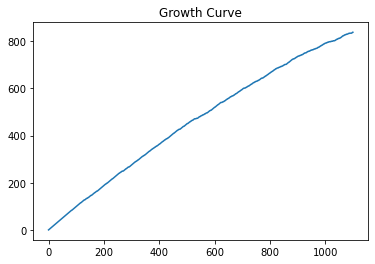

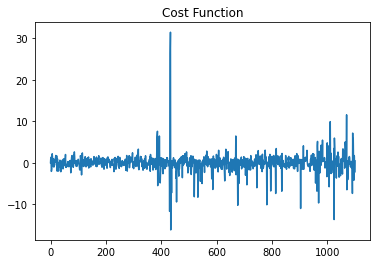

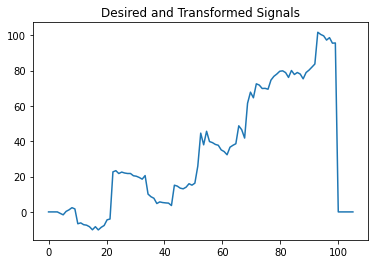

In [10]:
### DELETE LATER ###
mean = 0
var = 1
L = 5002
y = np.random.normal(mean, var, L)
h = np.array([-0.8, 0.7])
t = np.convolve(h, y)[0:L]
q = t + 0.25*(t**2) + 0.11*(t**3)
P = np.sum(q**2) / L
SNR = 10**(15/10)
xn = q + np.sqrt(P/SNR) * np.random.normal(0, 1, L)
x = xn[2:5002]
d = y[0:5000]

regularizer = 1e-3
step_size = 0.001
embedding_size = 5
kernel_size = 1
entropy_kernel_size = 10
threshold = 0.001
forgetting_factor = 0.99
J3, y3, growth3, a3 = QKLMS_MCC(x[0:1100], d[0:1100], kernel_size, entropy_kernel_size, embedding_size, step_size, threshold)
J, y, growth, a = QKRLS_MCC(x[0:1100], d[0:1100], regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold)
J2, y2, growth2, a2 = QKRLS_MSE(x[0:1100], d[0:1100], regularizer, kernel_size, embedding_size, threshold)
#y1 = KernelFilter(x[0:250], a, kernel_size, embedding_size)
y1 = GenerateTrajectory(x[0:5], a, kernel_size, embedding_size, 100)

print(y.size, y1.size, a.size)

y = y[0:200]
y1 = y1[0:200]

# plot output wave
plt.plot(np.linspace(0, np.size(growth), np.size(growth)), growth)
plt.title("Growth Curve")
plt.show()

plt.plot(np.linspace(0, np.size(J), np.size(J)), J)
plt.title("Cost Function")
plt.show()

#plt.plot(np.linspace(0, np.size(y), np.size(y)), y)
plt.plot(np.linspace(0, np.size(y1), np.size(y1)), y1)
plt.title("Desired and Transformed Signals")
plt.show()
### DELETE LATER ###

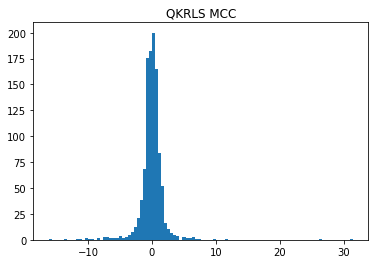

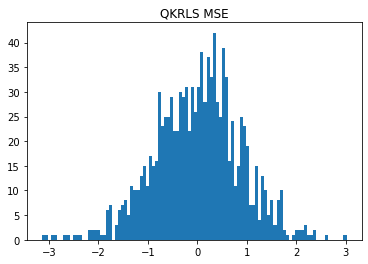

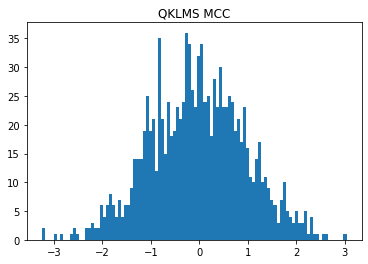

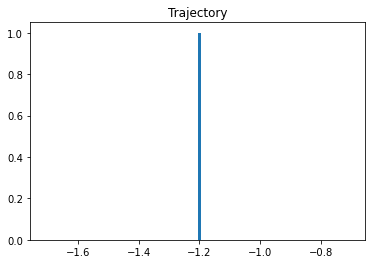

In [12]:
# histograms
hist1 = plt.hist(J, bins = 100)
plt.title("QKRLS MCC")
plt.show()

hist2 = plt.hist(J2, bins = 100)
plt.title("QKRLS MSE")
plt.show()

hist2 = plt.hist(J3, bins = 100)
plt.title("QKLMS MCC")
plt.show()

hist2 = plt.hist(y1[0:100] - d[0:100], bins = 100)
plt.title("Trajectory")
plt.show()